# EOBS seasonal means

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from warnings import warn

import cf_xarray as cfxr
import cordex as cx
import dask
import xarray as xr
import xesmf as xe
from dask.distributed import Client
from evaltools import obs
from evaltools.source import get_source_collection, open_and_sort
#from evaltools.utils import short_iid

dask.config.set(scheduler="single-threaded")

In [3]:
def short_iid(iid, attrs=None):
    """
    Convert a dataset ID to a short ID.

    Parameters:
    iid (str): The dataset ID.
    attrs (dict): The dataset attributes.

    Returns:
    str: The short ID.
    """
    if attrs is None:
        attrs = ["institution_id", "source_id", "driving_source_id", "experiment_id"]
    return dict_to_iid({k: v for k, v in iid_to_dict(iid).items() if k in attrs})

def dict_to_iid(attrs, drop=None):
    """
    Convert a dictionary of dataset attributes to a dataset ID.

    Parameters:
    attrs (dict): The dataset attributes.

    Returns:
    str: The dataset ID.
    """
    if drop is None:
        drop = []
    return ".".join(v for k, v in attrs.items() if k not in drop)

def iid_to_dict(iid, attrs=None):
    """
    Convert a dataset ID and its attributes to a dictionary.

    Parameters:
    dset_id (str): The dataset ID.
    attrs (dict): The dataset attributes.

    Returns:
    dict: The dataset ID and attributes as a dictionary.
    """
    if attrs is None:
        attrs = default_attrs
    values = iid.split(".")
    return dict(zip(attrs, values))

In [4]:
client = Client(dashboard_address="localhost:8000", threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8000/status,
Dashboard: http://127.0.0.1:8000/status,Workers: 16
Total threads: 16,Total memory: 125.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37863,Workers: 16
Dashboard: http://127.0.0.1:8000/status,Total threads: 16
Started: Just now,Total memory: 125.79 GiB
Comm: tcp://127.0.0.1:34337,Total threads: 1
Dashboard: http://127.0.0.1:38517/status,Memory: 7.86 GiB
Nanny: tcp://127.0.0.1:45581,


In [5]:
def add_bounds(ds, mip_era = 'CMIP6'):
    if "longitude" not in ds.cf.bounds and "latitude" not in ds.cf.bounds:
        if mip_era == 'CMIP6':
            ds = cx.transform_bounds(ds, trg_dims=("vertices_lon", "vertices_lat"))
        elif mip_era == 'CMIP5':
            ds = cx.transform_bounds(ds, trg_dims=("lon_vertices", "lat_vertices"))
    if mip_era == 'CMIP6':
        ds = ds.assign_coords(
            lon_b=cfxr.bounds_to_vertices(
                ds.vertices_lon, bounds_dim="vertices", order="counterclockwise"
            ),
            lat_b=cfxr.bounds_to_vertices(
                ds.vertices_lat, bounds_dim="vertices", order="counterclockwise"
            ),
        )
    elif mip_era == 'CMIP5':
        ds = ds.assign_coords(
            lon_b=cfxr.bounds_to_vertices(
                ds.lon_vertices, bounds_dim="vertices", order="counterclockwise"
            ),
            lat_b=cfxr.bounds_to_vertices(
                ds.lat_vertices, bounds_dim="vertices", order="counterclockwise"
            ),
    )
    return ds


def mask_with_sftlf(ds, sftlf=None):
    if sftlf is None and "sftlf" in ds:
        sftlf = ds["sftlf"]
        for var in ds.data_vars:
            if var != "sftlf":
                ds[var] = ds[var].where(sftlf > 0)
        ds["mask"] = sftlf > 0
    else:
        warn(f"sftlf not found in dataset: {ds.source_id}")
    return ds


def open_datasets(variables, frequency="mon", driving_source_id="ERA5", mask=False, add_missing_bounds=False):
    catalog = get_source_collection(variables, frequency, driving_source_id,
                                    add_fx=["areacella", "sftlf"])
    dsets = open_and_sort(catalog, merge=True)
    if mask is True:
        for ds in dsets.values():
            mask_with_sftlf(ds)
    if add_missing_bounds is True:
        for dset_id, ds in dsets.items():
            if driving_source_id == 'ERA5':
                dsets[dset_id] = add_bounds(ds, mip_era='CMIP6')
            elif driving_source_id == 'ECMWF-ERAINT':
                dsets[dset_id] = add_bounds(ds, mip_era='CMIP5')                
    return dsets


def create_cordex_grid(domain_id, mip_era = 'CMIP6'):
    grid = cx.domain(domain_id, bounds=True, mip_era=mip_era)
    # grid["lon"].attrs = {}
    # grid["vertices_lat"].attrs = {}
    if mip_era == 'CMIP6':
        lon_b = cfxr.bounds_to_vertices(
            grid.vertices_lon, bounds_dim="vertices", order="counterclockwise"
        )
        lat_b = cfxr.bounds_to_vertices(
            grid.vertices_lat, bounds_dim="vertices", order="counterclockwise"
        )
    elif mip_era == 'CMIP5':
        lon_b = cfxr.bounds_to_vertices(
            grid.lon_vertices, bounds_dim="vertices", order="counterclockwise"
        )
        lat_b = cfxr.bounds_to_vertices(
            grid.lat_vertices, bounds_dim="vertices", order="counterclockwise"
        )      
    return grid.assign_coords(lon_b=lon_b, lat_b=lat_b)


def create_regridder(source, target, method="bilinear"):
    regridder = xe.Regridder(source, target, method=method)
    return regridder


def regrid(ds, regridder):
    ds_regrid = regridder(ds)
    for var in ds.data_vars:
        if var not in ["mask", "sftlf"]:
            continue
            #ds_regrid[var] = ds_regrid[var].where(ds_regrid["mask"] > 0.0)
    return ds_regrid


def regrid_dsets(dsets, target_grid, method="bilinear"):
    for dset_id, ds in dsets.items():
        try:
            mapping = ds.cf["grid_mapping"].grid_mapping_name
        except Exception as e:
            prin("problmes with grid_mapping definition")
            continue
        if mapping == "rotated_latitude_longitude":
            dsets[dset_id] = ds.cx.rewrite_coords(coords="all")
        else:
            print(f"regridding {dset_id} with grid_mapping: {mapping}")
            regridder = create_regridder(ds, target_grid, method=method)
            print(regridder)
            dsets[dset_id] = regrid(ds, regridder)
    return dsets

In [8]:
driving_source_id = 'ECMWF-ERAINT'# ECMWF-ERAINT/ERA5

if driving_source_id == 'ERA5':

    default_attrs = [
        "project_id",
        "domain_id",
        "institution_id",
        "driving_source_id",
        "driving_experiment_id",
        "driving_variant_label",
        "source_id",
        "version_realization",
        #'frequency',
        #'variable_id',
        "version",
    ]

elif driving_source_id == 'ECMWF-ERAINT':

    default_attrs = [
    
        "project_id",
        "domain_id",
        "institution_id",
        "driving_source_id",
        "driving_experiment_id",
        "driving_variant_label",
        "source_id",
        "version_realization",
        "frequency",
        "version"
    ]

dsets = open_datasets(["tas"], frequency="mon", driving_source_id = driving_source_id)

Found: ['ALADIN53', 'ALADIN63', 'ALARO-0', 'CCLM4-8-17', 'COSMO-crCLIM-v1-1', 'HadREM3-GA7-05', 'RACMO22E', 'RCA4', 'REMO2009', 'REMO2015', 'RegCM4-2'] for variables: ['tas']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.variable_id.version'


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarray_o

Found 22 datasets
merging: CORDEX.EUR-11.CLMcom.ECMWF-ERAINT.evaluation.r0i0p0.CCLM4-8-17.v1.v20140515
merging: CORDEX.EUR-11.CLMcom.ECMWF-ERAINT.evaluation.r1i1p1.CCLM4-8-17.v1.v20140515
merging: CORDEX.EUR-11.CLMcom-ETH.ECMWF-ERAINT.evaluation.r0i0p0.COSMO-crCLIM-v1-1.v1.v20191210
merging: CORDEX.EUR-11.CLMcom-ETH.ECMWF-ERAINT.evaluation.r1i1p1.COSMO-crCLIM-v1-1.v1.v20191210
merging: CORDEX.EUR-11.CNRM.ECMWF-ERAINT.evaluation.r1i1p1.ALADIN53.v1.v20150127
merging: CORDEX.EUR-11.CNRM.ECMWF-ERAINT.evaluation.r1i1p1.ALADIN63.v1.v20191118
merging: CORDEX.EUR-11.DHMZ.ECMWF-ERAINT.evaluation.r1i1p1.RegCM4-2.v1.v20160112
merging: CORDEX.EUR-11.DHMZ.ECMWF-ERAINT.evaluation.r1i1p1.RegCM4-2.v1.v20150527
merging: CORDEX.EUR-11.GERICS.ECMWF-ERAINT.evaluation.r0i0p0.REMO2015.v1.v20180813
merging: CORDEX.EUR-11.GERICS.ECMWF-ERAINT.evaluation.r1i1p1.REMO2015.v1.v20180813
merging: CORDEX.EUR-11.KNMI.ECMWF-ERAINT.evaluation.r1i1p1.RACMO22E.v1.v20140218
merging: CORDEX.EUR-11.KNMI.ECMWF-ERAINT.evaluati

In [9]:
rotated_grid = create_cordex_grid("EUR-11", mip_era="CMIP6")
dsets = regrid_dsets(dsets, rotated_grid, method="bilinear")

regridding CORDEX.EUR-11.CNRM.ECMWF-ERAINT.evaluation.r1i1p1.ALADIN53.v1.v20150127 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (453, 453) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX.EUR-11.CNRM.ECMWF-ERAINT.evaluation.r1i1p1.ALADIN63.v1.v20191118 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (453, 453) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX.EUR-11.DHMZ.ECMWF-ERAINT.evaluation.r1i1p1.RegCM4-2.v1.v20160112 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_551x551_

In [10]:
eobs = obs.eobs(add_mask=False)
# unmapped_to_nan, see https://github.com/pangeo-data/xESMF/issues/56
regridder = xe.Regridder(eobs, rotated_grid, method="bilinear", unmapped_to_nan=True)
eobs_on_rotated = regridder(eobs)

In [11]:
def seasonal_mean(da):
    """Optimized function to calculate seasonal averages from time series of monthly means

    based on: https://xarray.pydata.org/en/stable/examples/monthly-means.html
    """
    # Get number od days for each month
    month_length = da.time.dt.days_in_month
    # Calculate the weights by grouping by 'time.season'.
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    # np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (
        (da * weights).groupby("time.season").sum(dim="time", skipna=True, min_count=1)
    )

In [12]:
%%time

period = slice("1981", "2000")
eobs_seasmean = seasonal_mean(eobs_on_rotated.tg.sel(time=period)).compute()

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 15.31 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 2.91 s, sys: 701 ms, total: 3.61 s
Wall time: 23.4 s


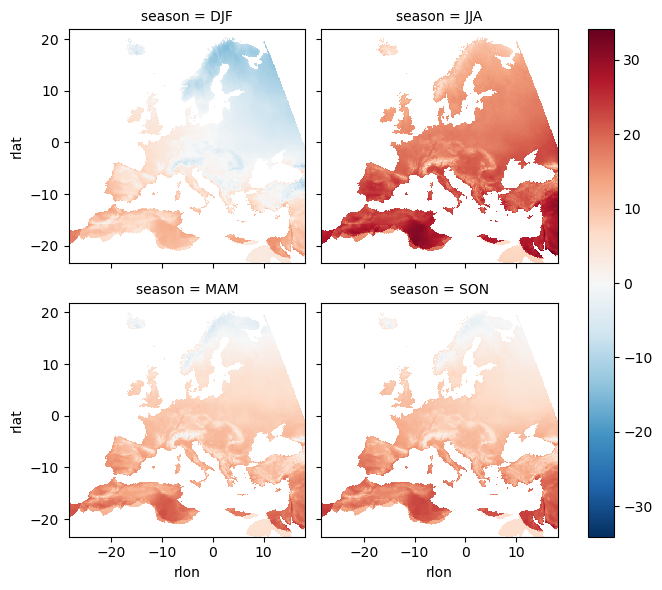

In [13]:
eobs_seasmean.plot(col="season", col_wrap=2)

In [14]:
variable = "tas"

#diffs = {
#    dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
#    - (eobs_seasmean + 273.15)
#    for dset_id, ds in dsets.items()
#}

diffs = {
    dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute() - (eobs_seasmean + 273.15)
    for dset_id, ds in dsets.items() if 'tas' in ds.variables
}
        
seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(map(lambda x: short_iid(x, ["source_id"]), diffs.keys())),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

In [15]:
# seasonal_bias.tas.plot(col="season", row="dset_id", vmin=-8, vmax=8, cmap="RdBu_r")

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/cf_xarray/accessor.py:700: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  unused_keys = set(attribute.keys()) - set(inverted)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/cf_xarray/accessor.py:701: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for key, value in attribute.items():
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/cf_xarray/accessor.py:709: FutureWarning: The return type of `Dataset.dims` will b

0 0 0 DJF CCLM4-8-17
0 1 4 DJF REMO2015
0 2 8 DJF ALADIN63
0 3 12 DJF RACMO22E
1 0 1 JJA CCLM4-8-17
1 1 5 JJA REMO2015
1 2 9 JJA ALADIN63
1 3 13 JJA RACMO22E
2 0 2 MAM CCLM4-8-17
2 1 6 MAM REMO2015
2 2 10 MAM ALADIN63
2 3 14 MAM RACMO22E
3 0 3 SON CCLM4-8-17
3 1 7 SON REMO2015
3 2 11 SON ALADIN63
3 3 15 SON RACMO22E


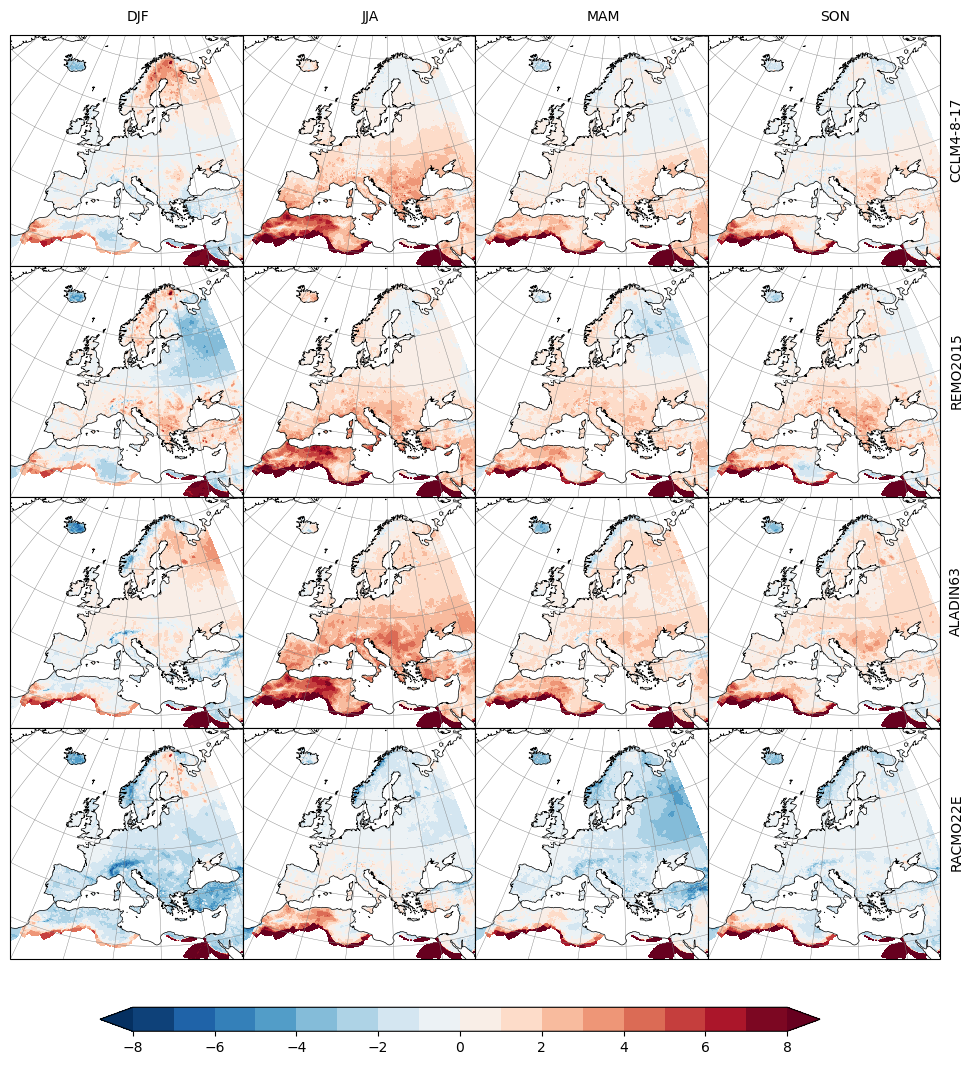

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

ds = seasonal_bias.sel(dset_id = ["CCLM4-8-17", "REMO2015", "ALADIN63", "RACMO22E"])
#ds = seasonal_bias.sel(dset_id = ["ICON-CLM-202407-1-1", "REMO2020", "HCLIM43-ALADIN", "RACMO23E"])


nrows = ds.dset_id.size
ncols = ds.season.size

aspect = ds.cf.dims["Y"] / ds.cf.dims["X"]

# ds = diffs.where(~diffs.isnull(), drop=True)
tas = ds.tas
# pole = ds.cf["grid_mapping"]
# transform = ccrs.RotatedPole(
#    pole_latitude=pole.grid_north_pole_latitude,
#    pole_longitude=pole.grid_north_pole_longitude,
# )
transform = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162.0)
projection = transform

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    subplot_kw={"projection": projection},
    figsize=(12, 12),
    sharex=True,
    sharey=True,
    gridspec_kw={"wspace": 0, "hspace": 0},
    #  aspect_ratio=0.97,
)

# plt.subplots_adjust(wspace=0, hspace=0)

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs = axs.flatten()

# Loop over all of the models
for i, season in enumerate(ds.season.values):
    for j, dset_id in enumerate(ds.dset_id.values):
        pos = i + j * ncols
        print(i, j, pos, season, dset_id)
        # Select the week 1 forecast from the specified model
        data = ds.tas.isel(season=i, dset_id=j)

        # Add the cyclic point
        # data,lons=add_cyclic_point(data,coord=ds['lon'])

        # Contour plot
        cs = axs[pos].contourf(
            ds.cf["X"],
            ds.cf["Y"],
            data,
            transform=transform,
            # Define the levels for contourf
            levels=np.arange(-8, 9, 1),
            # cmap="coolwarm",
            extend="both",
            # vmin=-8, vmax=8,
            cmap="RdBu_r",
        )

        # if i == 3:
        #    axs[pos].set_ylabel(dset_id)

        axs[pos].set_aspect(round(aspect, 3))

        # Title each subplot with the name of the model
        # axs[pos].set_title(pos)

        # Draw the coastines for each subplot
        axs[pos].coastlines(resolution="50m", color="black", linewidth=0.5)

        gl = axs[pos].gridlines(
            draw_labels=False,
            linewidth=0.3,
            color="gray",
            xlocs=range(-180, 180, 10),
            ylocs=range(-90, 90, 10),
        )

        # axs[pos].xaxis.set_tick_position('bottom')
        # axs[pos].yaxis.set_tick_position('left')

        # Longitude labels
        # https://stackoverflow.com/questions/35479508/cartopy-set-xlabel-set-ylabel-not-ticklabels
        if i == 3:
            axs[pos].text(
                1.1,
                0.55,
                dset_id,
                va="bottom",
                ha="center",
                rotation="vertical",
                rotation_mode="anchor",
                transform=axs[pos].transAxes,
            )
        if j == 0:
            axs[pos].text(
                0.55,
                1.05,
                season,
                va="bottom",
                ha="center",
                rotation="horizontal",
                rotation_mode="anchor",
                transform=axs[pos].transAxes,
            )
        # if i == 0:
        # axs[pos].set_title(season)
        #    axs[pos].set_xlabel(dset_id)
        #    axs[pos].set_xticks(range(-180, 180, 10), crs=ccrs.PlateCarree())
        # lon_formatter = cticker.LongitudeFormatter()
        # axs[i].xaxis.set_major_formatter(lon_formatter)
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        axs[pos].xaxis.set_major_formatter(lon_formatter)
        axs[pos].yaxis.set_major_formatter(lat_formatter)

        # # Latitude labels
        # axs[pos].set_yticks(range(-90, 90, 10), crs=ccrs.PlateCarree())
        # lat_formatter = cticker.LatitudeFormatter()
        # axs[i].yaxis.set_major_formatter(lat_formatter)


# Adjust the location of the subplots on the page to make room for the colorbar
# fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.08, hspace=0.08)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])

# Draw the colorbar
cbar = fig.colorbar(cs, cax=cbar_ax, orientation="horizontal")

plt.subplots_adjust(wspace=0, hspace=0)


# Add a big title at the top
# plt.suptitle('SubX Week 1 2m Temperature Anomalies ($^\circ$C): Apr 16, 2020 Initialized Forecasts')
#plt.savefig('CMIP6_eobs.pdf', bbox_inches='tight', transparent=True, pad_inches=0)